# RNN Sentiment Classification with NusaX-Sentiment Dataset

This notebook explores different RNN architectures for Indonesian sentiment classification using the NusaX-Sentiment dataset.


## 1. Setup and Imports

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Import our custom modules
from text_preprocessor import TextPreprocessor
from keras_rnn import RNNSentimentClassifier, ModelComparator

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")


TensorFlow version: 2.19.0
GPU Available: []


## 2. Data Loading and Preprocessing

In [2]:
preprocessor = TextPreprocessor(
    vocab_size=5000,
    max_sequence_length=100,
    embedding_dim=128
)

# Load NusaX-Sentiment dataset
train_path = 'datasets/train.csv'  
test_path = 'datasets/test.csv'    
valid_path = 'datasets/valid.csv'  

data = preprocessor.load_nusax_data(train_path, test_path, valid_path)

print(f"Training samples: {len(data['train']['texts'])}")
print(f"Validation samples: {len(data['valid']['texts'])}")
print(f"Test samples: {len(data['test']['texts'])}")


Training samples: 500
Validation samples: 100
Test samples: 400


In [3]:
#Preprocessing
preprocessor.fit_on_texts(data['train']['texts'], data['train']['labels'])

vocab_info = preprocessor.get_vocab_info()
print("Vocabulary Information:")
for key, value in vocab_info.items():
    print(f"{key}: {value}")


Vocabulary size: 2836
Number of classes: 3
Classes: ['negative' 'neutral' 'positive']
First 10 vocabulary words: ['', '[UNK]', np.str_('yang'), np.str_('di'), np.str_('dan'), np.str_('tidak'), np.str_('saya'), np.str_('dengan'), np.str_('enak'), np.str_('ini')]

Sample tokenization:
Text: Nikmati cicilan 0% hingga 12 bulan untuk pemesanan tiket pesawat air asia dengan kartu kredit bni!
Tokens: [1758 1080 1145  196 2834  198   11  607  177  847  283  547    7  507
  496  415    0    0    0    0]...
Vocabulary Information:
vocab_size: 2836
first_10_tokens: ['', '[UNK]', np.str_('yang'), np.str_('di'), np.str_('dan'), np.str_('tidak'), np.str_('saya'), np.str_('dengan'), np.str_('enak'), np.str_('ini')]
max_sequence_length: 100
embedding_dim: 128


In [5]:
# Prepare Datasets
BATCH_SIZE = 32

train_dataset = preprocessor.prepare_dataset(
    data['train']['texts'], 
    data['train']['labels'], 
    batch_size=BATCH_SIZE, 
    shuffle=True
)

valid_dataset = preprocessor.prepare_dataset(
    data['valid']['texts'], 
    data['valid']['labels'], 
    batch_size=BATCH_SIZE, 
    shuffle=False
)

test_dataset = preprocessor.prepare_dataset(
    data['test']['texts'], 
    data['test']['labels'], 
    batch_size=BATCH_SIZE, 
    shuffle=False
)

print("Datasets prepared successfully!")

Datasets prepared successfully!


## 3. Baseline Model Training

### 3.1 Simple Baseline for Pipeline Verification

In [ ]:
print("Building simple baseline model...")

simple_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        input_dim=preprocessor.vocab_size_actual,
        output_dim=64,
        mask_zero=True
    ),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(preprocessor.num_classes, activation='softmax')
])

simple_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("\nTraining simple baseline...")
simple_history = simple_model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=10,
    verbose=1
)

simple_loss, simple_acc = simple_model.evaluate(test_dataset, verbose=0)
print("\nSimple Baseline Results:")
print(f"Test Accuracy: {simple_acc:.4f}")
print(f"Test Loss: {simple_loss:.4f}")


Building simple baseline model...
Simple baseline model:


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


Training simple baseline...
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.3580 - loss: 1.0942 - val_accuracy: 0.5600 - val_loss: 1.0781
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4705 - loss: 1.0661 - val_accuracy: 0.4600 - val_loss: 1.0629
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4462 - loss: 1.0551 - val_accuracy: 0.5800 - val_loss: 1.0485
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5852 - loss: 1.0175 - val_accuracy: 0.6000 - val_loss: 1.0274
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5765 - loss: 0.9987 - val_accuracy: 0.6000 - val_loss: 0.9994
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6122 - loss: 0.9342 - val_accuracy: 0.6100 - val_loss: 0.9593
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7130 - loss: 0.8577 - val_accuracy: 0.6600 - val_loss: 0.9123
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8168 - loss: 0.7717 - va

### 3.2 RNN-Based Sentiment Classifier 

In [ ]:
baseline_classifier = RNNSentimentClassifier(
    vocab_size=preprocessor.vocab_size_actual,
    embedding_dim=preprocessor.embedding_dim,
    max_sequence_length=preprocessor.max_sequence_length,
    num_classes=preprocessor.num_classes
)

baseline_model = baseline_classifier.build_model(
    num_rnn_layers=1,
    rnn_units=64,
    bidirectional=True,
    dropout_rate=0.3,
    dense_units=32
)


Baseline Model Architecture:


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_dropout (Dropout)     │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_rnn_1             │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_dense (Dropout)         │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
print("Training baseline model...")
baseline_history = baseline_classifier.train(
    train_dataset=train_dataset,
    validation_dataset=valid_dataset,
    epochs=20,
    verbose=1
)

baseline_metrics = baseline_classifier.evaluate(test_dataset)

print("\nBaseline Model Results:")
print(f"Test Accuracy: {baseline_metrics['test_accuracy']:.4f}")
print(f"Test Loss: {baseline_metrics['test_loss']:.4f}")
print(f"Macro F1-Score: {baseline_metrics['macro_f1']:.4f}")


Training baseline model...
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 115ms/step - accuracy: 0.3774 - loss: 1.1279 - val_accuracy: 0.5000 - val_loss: 1.0663 - learning_rate: 0.0010
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.4210 - loss: 1.0464 - val_accuracy: 0.4800 - val_loss: 1.0345 - learning_rate: 0.0010
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.4528 - loss: 1.0240 - val_accuracy: 0.4700 - val_loss: 0.9915 - learning_rate: 0.0010
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.5539 - loss: 0.9574 - val_accuracy: 0.5400 - val_loss: 0.9737 - learning_rate: 0.0010
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.5624 - loss: 0.9133 - val_accuracy: 0.5200 - val_loss: 0.9708 - learning_rate: 0.0010
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.6469 - loss: 0.8549 - val_accuracy: 0.5600 - val_loss: 0.9376 - learning_rate: 0.0010
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.6

## 4. Hyperparameter Analysis

### 4.1 Effect of Number of RNN Layers

In [24]:
layer_comparator = ModelComparator()

layer_configs = [1, 2, 3]
layer_results = {}

for num_layers in layer_configs:
    print(f"\n{'='*50}")
    print(f"Training model with {num_layers} RNN layer(s)")
    print(f"{'='*50}")
    
    classifier = RNNSentimentClassifier(
        vocab_size=preprocessor.vocab_size_actual,
        embedding_dim=preprocessor.embedding_dim,
        max_sequence_length=preprocessor.max_sequence_length,
        num_classes=preprocessor.num_classes
    )

    model = classifier.build_model(
        num_rnn_layers=num_layers,
        rnn_units=64,
        bidirectional=True,
        dropout_rate=0.3,
        dense_units=32
    )

    history = classifier.train(
        train_dataset=train_dataset,
        validation_dataset=valid_dataset,
        epochs=15,
        verbose=0
    )

    metrics = classifier.evaluate(test_dataset)
    
    config_name = f"{num_layers} Layer(s)"
    layer_results[config_name] = {
        'classifier': classifier,
        'metrics': metrics,
        'history': history
    }

    layer_comparator.add_result(config_name, metrics, history)

    print(f"Results for {config_name}:")
    print(f"  Accuracy   : {metrics['test_accuracy']:.4f}")
    print(f"  Loss       : {metrics['test_loss']:.4f}")
    print(f"  Macro F1   : {metrics['macro_f1']:.4f}")


Training model with 1 RNN layer(s)
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
Results for 1 Layer(s):
  Accuracy   : 0.6125
  Loss       : 1.0064
  Macro F1   : 0.5959

Training model with 2 RNN layer(s)
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step
Results for 2 Layer(s):
  Accuracy   : 0.6525
  Loss       : 0.8652
  Macro F1   : 0.6257

Training model with 3 RNN layer(s)
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step
Results for 3 Layer(s):
  Accuracy   : 0.5425
  Loss       : 0.9051
  Macro F1   : 0.5243



Comparison of Different Numbers of RNN Layers:
  Configuration  Test Accuracy  Test Loss  Macro F1-Score
1    2 Layer(s)         0.6525   0.865226        0.625698
0    1 Layer(s)         0.6125   1.006416        0.595852
2    3 Layer(s)         0.5425   0.905089        0.524307


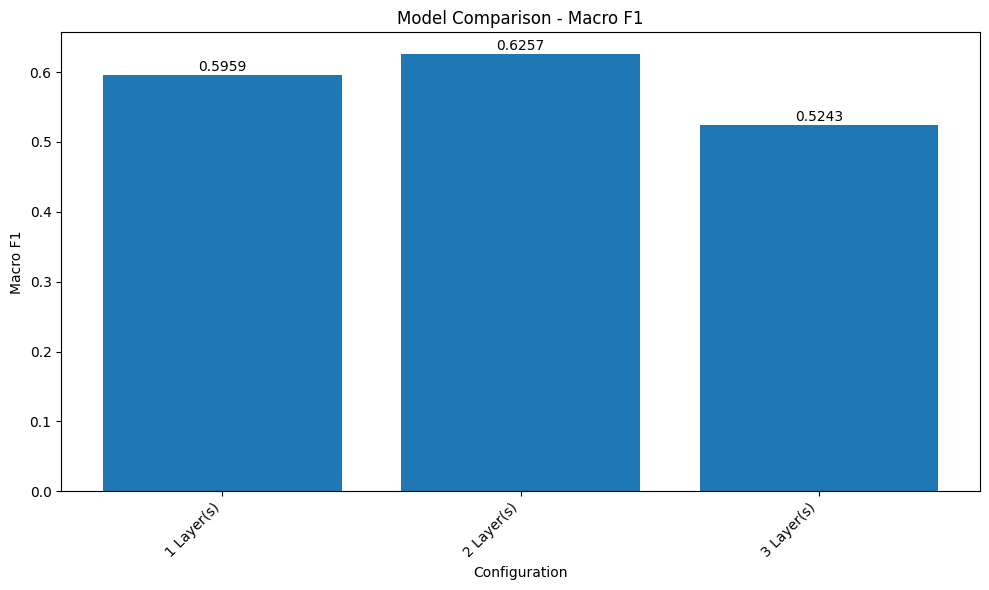

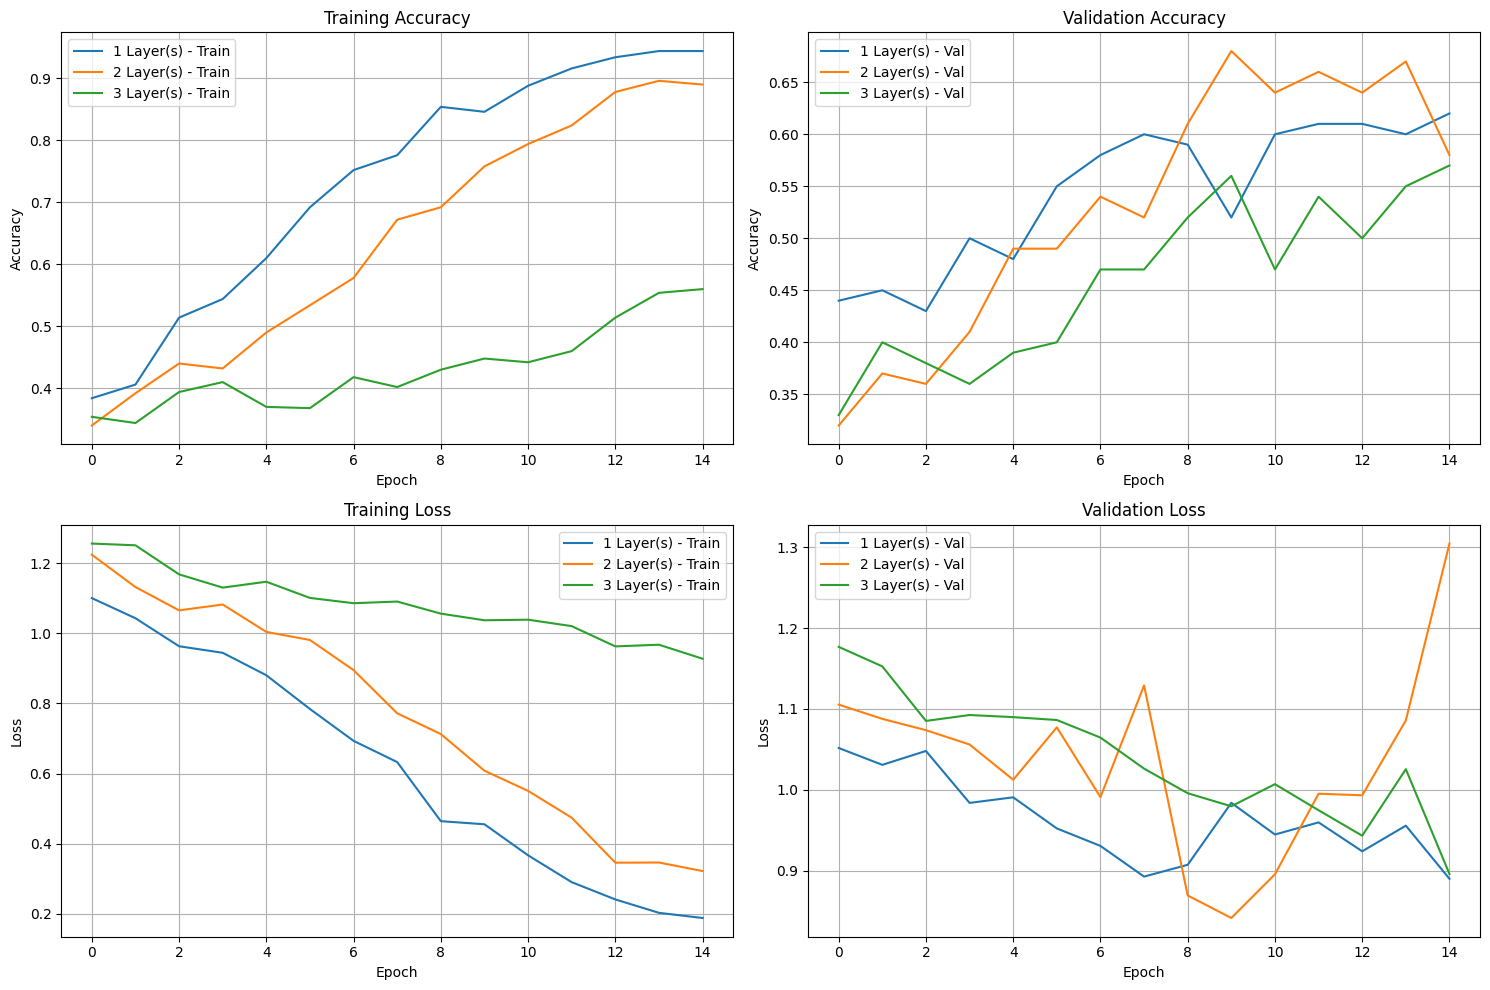

In [25]:
print("\nComparison of Different Numbers of RNN Layers:")
layer_comparison_df = layer_comparator.compare_results()
print(layer_comparison_df)

layer_comparator.plot_comparison(metric='macro_f1')
layer_comparator.plot_training_curves_comparison()


### 4.2 Effect of Number of RNN Cells per Layer

In [26]:
units_comparator = ModelComparator()

units_configs = [32, 64, 128]
units_results = {}

for units in units_configs:
    print(f"\n{'='*50}")
    print(f"Training model with {units} RNN units")
    print(f"{'='*50}")
    
    classifier = RNNSentimentClassifier(
        vocab_size=preprocessor.vocab_size_actual,
        embedding_dim=preprocessor.embedding_dim,
        max_sequence_length=preprocessor.max_sequence_length,
        num_classes=preprocessor.num_classes
    )

    model = classifier.build_model(
        num_rnn_layers=2, 
        rnn_units=units,
        bidirectional=True,
        dropout_rate=0.3,
        dense_units=32
    )

    history = classifier.train(
        train_dataset=train_dataset,
        validation_dataset=valid_dataset,
        epochs=15,
        verbose=0
    )

    metrics = classifier.evaluate(test_dataset)
    
    config_name = f"{units} Units"
    units_results[config_name] = {
        'classifier': classifier,
        'metrics': metrics,
        'history': history
    }

    units_comparator.add_result(config_name, metrics, history)

    print(f"Results for {config_name}:")
    print(f"  Accuracy   : {metrics['test_accuracy']:.4f}")
    print(f"  Loss       : {metrics['test_loss']:.4f}")
    print(f"  Macro F1   : {metrics['macro_f1']:.4f}")



Training model with 32 RNN units
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step
Results for 32 Units:
  Accuracy   : 0.6025
  Loss       : 0.9192
  Macro F1   : 0.5106

Training model with 64 RNN units
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step
Results for 64 Units:
  Accuracy   : 0.6675
  Loss       : 0.8049
  Macro F1   : 0.6311

Training model with 128 RNN units
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 180ms/step
Results for 128 Units:
  Accuracy   : 0.6100
  Loss       : 0.9108
  Macro F1   : 0.5748



Comparison of Different Numbers of RNN Units:
  Configuration  Test Accuracy  Test Loss  Macro F1-Score
1      64 Units         0.6675   0.804901        0.631054
2     128 Units         0.6100   0.910828        0.574839
0      32 Units         0.6025   0.919227        0.510566


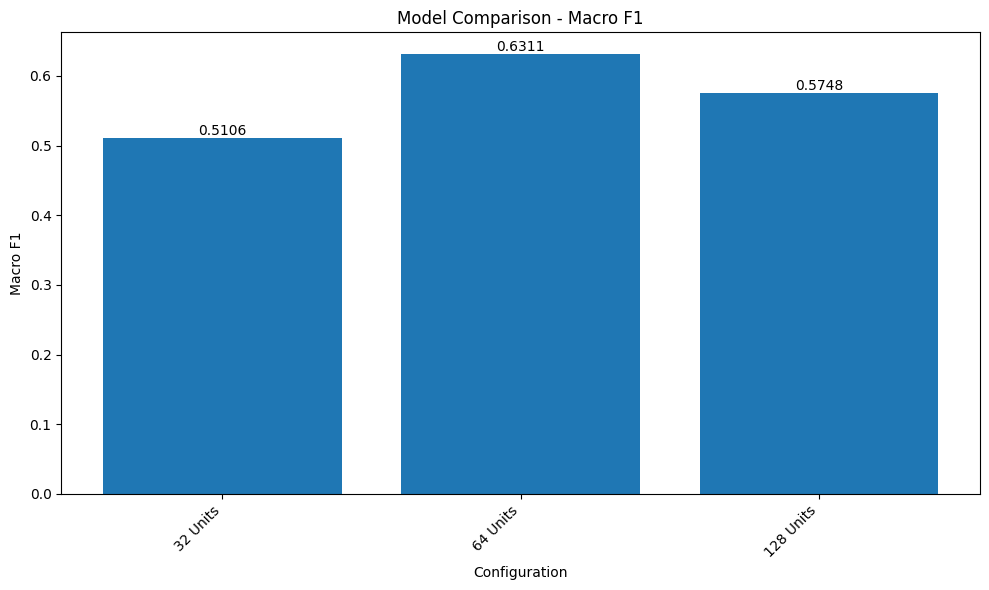

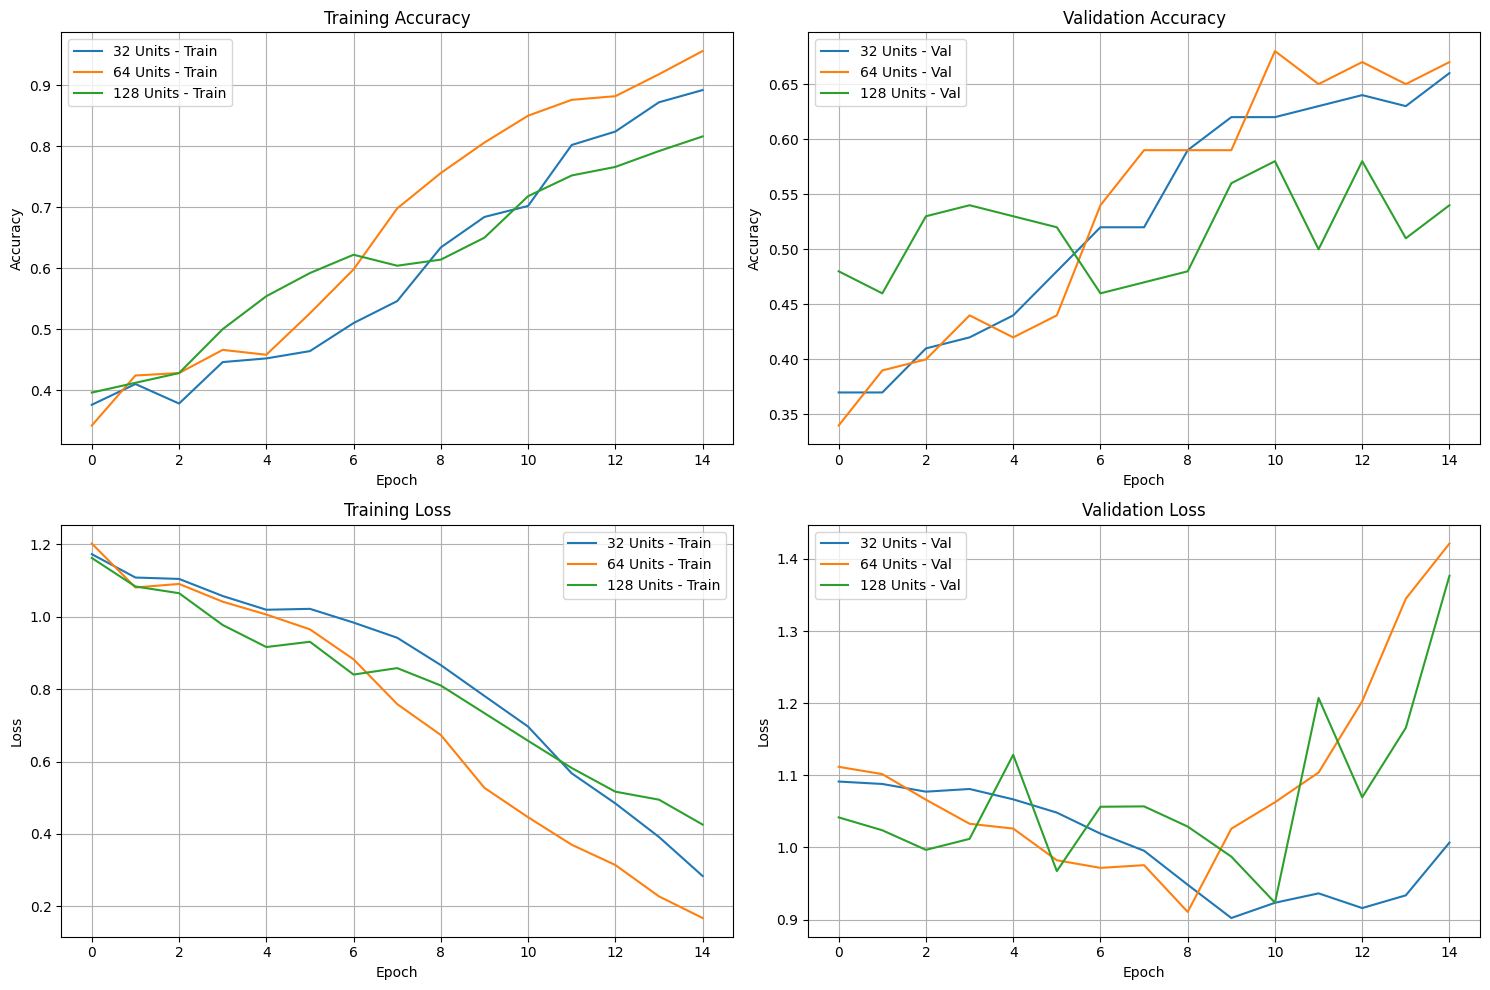

In [27]:
print("\nComparison of Different Numbers of RNN Units:")
units_comparison_df = units_comparator.compare_results()
print(units_comparison_df)

units_comparator.plot_comparison(metric='macro_f1')
units_comparator.plot_training_curves_comparison()


### 4.3 Effect of RNN Direction (Bidirectional vs Unidirectional)

In [28]:
direction_comparator = ModelComparator()

direction_configs = [True, False]
direction_results = {}

for bidirectional in direction_configs:
    direction_name = "Bidirectional" if bidirectional else "Unidirectional"
    print(f"\n{'='*50}")
    print(f"Training {direction_name} RNN model")
    print(f"{'='*50}")
    
    classifier = RNNSentimentClassifier(
        vocab_size=preprocessor.vocab_size_actual,
        embedding_dim=preprocessor.embedding_dim,
        max_sequence_length=preprocessor.max_sequence_length,
        num_classes=preprocessor.num_classes
    )

    model = classifier.build_model(
        num_rnn_layers=2,
        rnn_units=64,
        bidirectional=bidirectional,
        dropout_rate=0.3,
        dense_units=32
    )

    history = classifier.train(
        train_dataset=train_dataset,
        validation_dataset=valid_dataset,
        epochs=15,
        verbose=0
    )

    metrics = classifier.evaluate(test_dataset)

    config_name = direction_name
    direction_results[config_name] = {
        'classifier': classifier,
        'metrics': metrics,
        'history': history
    }

    direction_comparator.add_result(config_name, metrics, history)

    print(f"Results for {config_name}:")
    print(f"  Accuracy   : {metrics['test_accuracy']:.4f}")
    print(f"  Loss       : {metrics['test_loss']:.4f}")
    print(f"  Macro F1   : {metrics['macro_f1']:.4f}")



Training Bidirectional RNN model
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step
Results for Bidirectional:
  Accuracy   : 0.6150
  Loss       : 0.8976
  Macro F1   : 0.5502

Training Unidirectional RNN model
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step
Results for Unidirectional:
  Accuracy   : 0.5800
  Loss       : 0.8559
  Macro F1   : 0.5043



Comparison of Bidirectional vs Unidirectional RNN:
    Configuration  Test Accuracy  Test Loss  Macro F1-Score
0   Bidirectional          0.610   0.912895        0.574747
1  Unidirectional          0.585   0.864377        0.549066


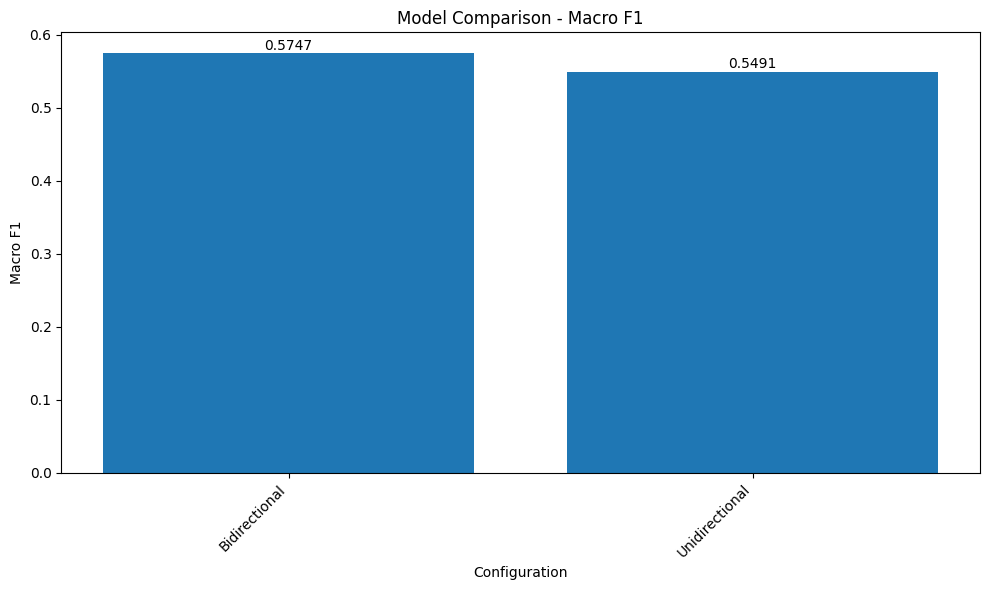

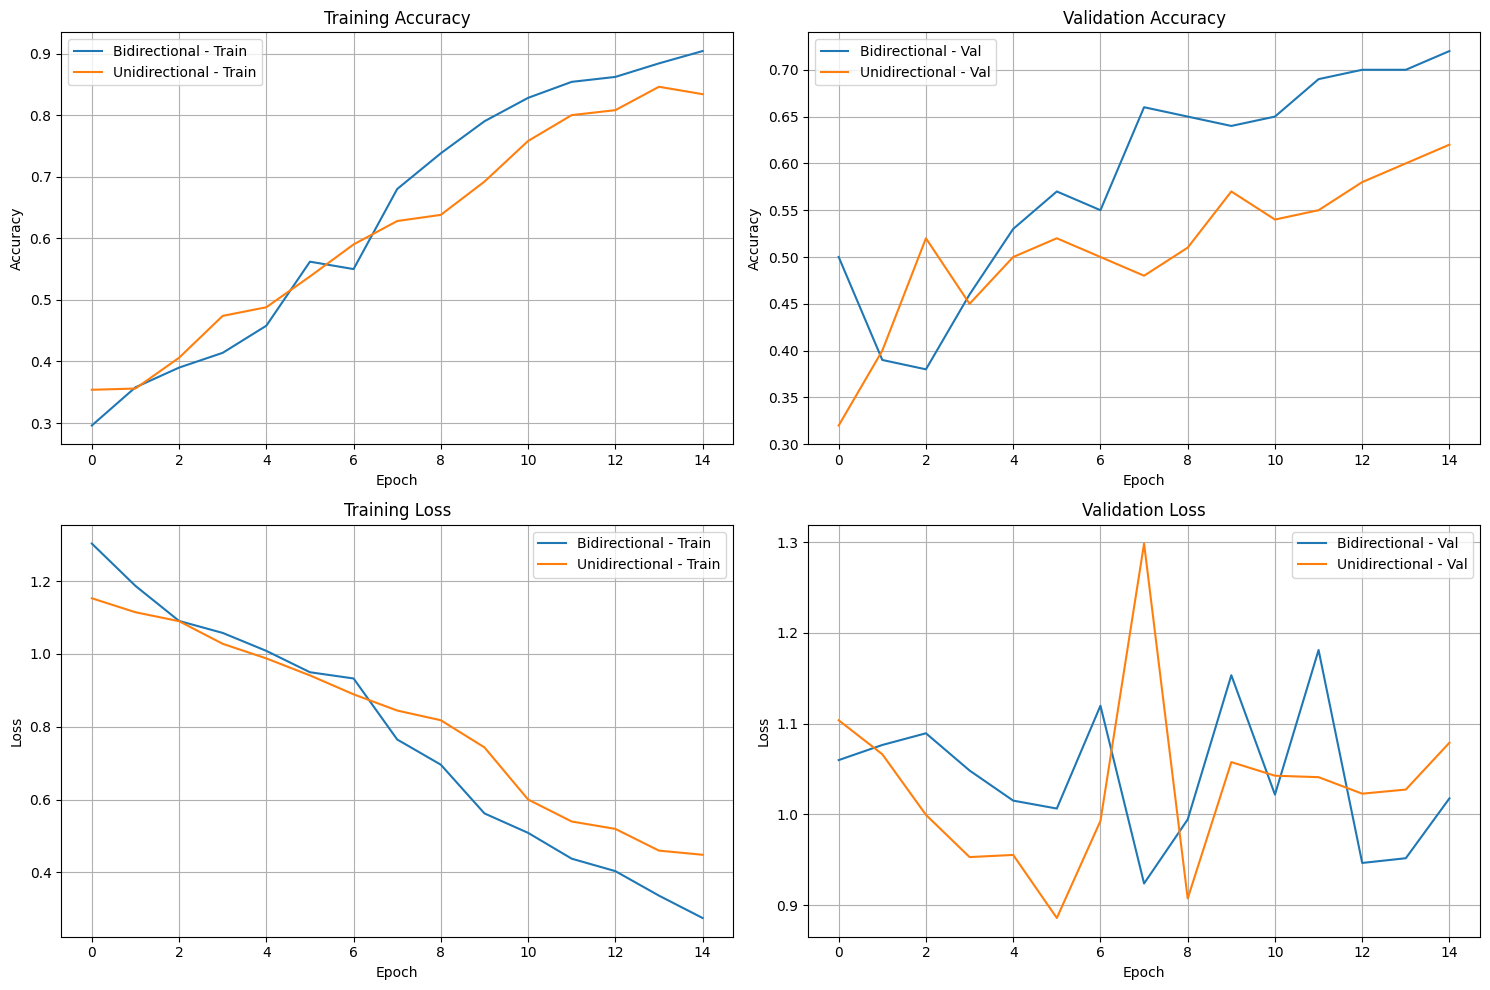

In [13]:
print("\nComparison of Bidirectional vs Unidirectional RNN:")
direction_comparison_df = direction_comparator.compare_results()
print(direction_comparison_df)

direction_comparator.plot_comparison(metric='macro_f1')
direction_comparator.plot_training_curves_comparison()

## 5. Final Model Selection and Training

In [14]:
print("Training final model with best configuration...")

final_classifier = RNNSentimentClassifier(
    vocab_size=preprocessor.vocab_size_actual,
    embedding_dim=preprocessor.embedding_dim,
    max_sequence_length=preprocessor.max_sequence_length,
    num_classes=preprocessor.num_classes
)

final_model = final_classifier.build_model(
    num_rnn_layers=2,     
    rnn_units=64,         
    bidirectional=True,     
    dropout_rate=0.3,
    dense_units=32
)

Training final model with best configuration...


In [15]:
final_history = final_classifier.train(
    train_dataset=train_dataset,
    validation_dataset=valid_dataset,
    epochs=50, 
    verbose=1
)

final_metrics = final_classifier.evaluate(test_dataset)
print("\nFinal Model Results:")
print(f"Test Accuracy: {final_metrics['test_accuracy']:.4f}")
print(f"Test Loss: {final_metrics['test_loss']:.4f}")
print(f"Macro F1-Score: {final_metrics['macro_f1']:.4f}")


Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 203ms/step - accuracy: 0.2770 - loss: 1.3067 - val_accuracy: 0.4100 - val_loss: 1.0945 - learning_rate: 0.0010
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.3337 - loss: 1.2707 - val_accuracy: 0.4000 - val_loss: 1.0773 - learning_rate: 0.0010
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 0.4634 - loss: 1.0633 - val_accuracy: 0.4300 - val_loss: 1.0622 - learning_rate: 0.0010
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 0.4257 - loss: 1.0469 - val_accuracy: 0.5000 - val_loss: 1.0127 - learning_rate: 0.0010
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 187ms/step - accuracy: 0.5264 - loss: 0.9913 - val_accuracy: 0.5000 - val_loss: 1.0244 - learning_rate: 0.0010
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 0.5575 - loss: 0.9435 - val_accuracy: 0.5300 - val_loss: 0.9663 - learning_rate: 0.0010
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 0.7017 - loss: 0.7896 -

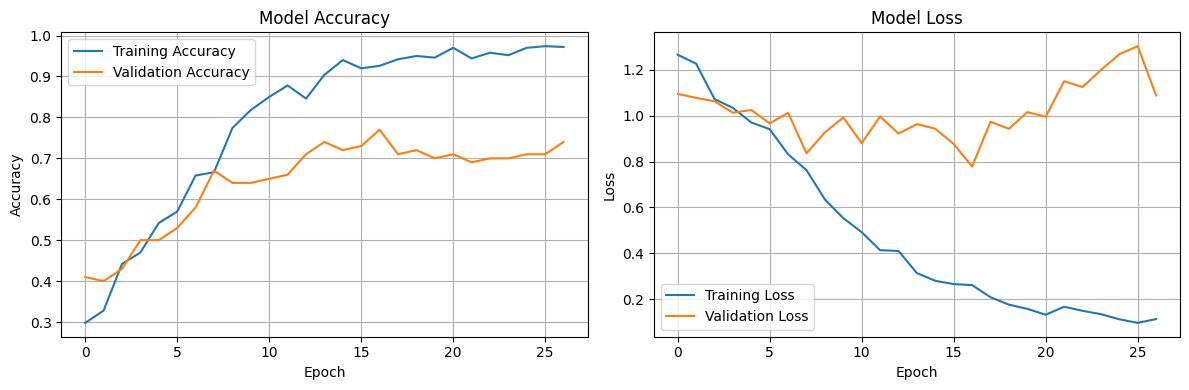


Detailed Classification Report:
              precision    recall  f1-score   support

    negative       0.66      0.72      0.69       153
     neutral       0.59      0.43      0.50        96
    positive       0.76      0.83      0.79       151

    accuracy                           0.69       400
   macro avg       0.67      0.66      0.66       400
weighted avg       0.68      0.69      0.68       400



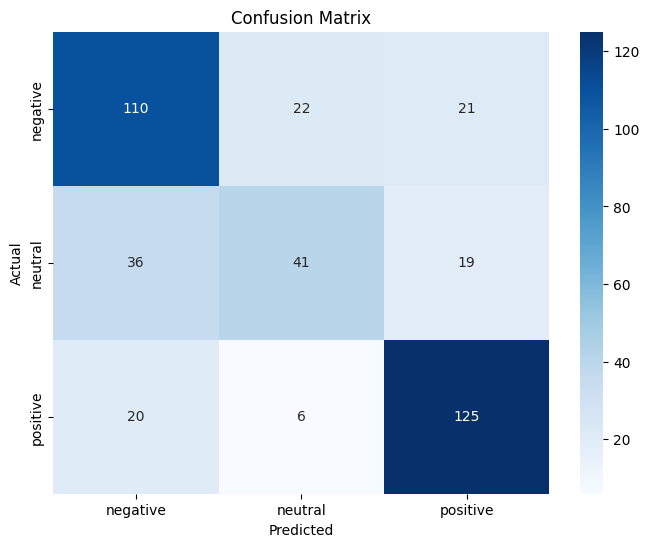

In [16]:
final_classifier.plot_training_history()

y_true = final_metrics['true_labels']
y_pred = final_metrics['predictions']
target_names = preprocessor.label_encoder.classes_

print("\nDetailed Classification Report:")
print(classification_report(y_true, y_pred, target_names=target_names))

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


## 6. Save Model

In [18]:
model_save_path = 'saved_models/final_rnn_sentiment_model.keras'
final_classifier.save_model(model_save_path)

weights_save_path = 'saved_models/final_rnn_weights.weights.h5'
final_classifier.save_weights(weights_save_path)

import pickle

preprocessor_info = {
    'vocab_size': preprocessor.vocab_size_actual,
    'embedding_dim': preprocessor.embedding_dim,
    'max_sequence_length': preprocessor.max_sequence_length,
    'num_classes': preprocessor.num_classes,
    'vocabulary': preprocessor.vectorizer.get_vocabulary(),
    'label_classes': preprocessor.label_encoder.classes_.tolist()
}

with open('saved_models/preprocessor_info.pkl', 'wb') as f:
    pickle.dump(preprocessor_info, f)

print("Model and preprocessor information saved successfully!")

Model saved to saved_models/final_rnn_sentiment_model.keras
Weights saved to saved_models/final_rnn_weights.weights.h5
Model and preprocessor information saved successfully!


## 7. From-Scratch Implementation

In [20]:
from rnn_from_scratch import (
    RNNFromScratch, build_scratch_model_from_keras_auto, 
    compare_keras_vs_scratch, extract_keras_architecture
)

print("Loading trained Keras model...")
keras_model = tf.keras.models.load_model(model_save_path)

print("\nExtracting model architecture...")
architecture = extract_keras_architecture(keras_model)
print(f"Model has {architecture['total_layers']} layers:")
for layer_info in architecture['layers']:
    print(f"  {layer_info['index']}: {layer_info['type']} - {layer_info['name']}")

print("\nBuilding from-scratch model...")
scratch_model = build_scratch_model_from_keras_auto(keras_model)

print("From-scratch model built successfully!")

Loading trained Keras model...

Extracting model architecture...
Model has 8 layers:
  0: Embedding - embedding
  1: Dropout - embedding_dropout
  2: Bidirectional - bidirectional_rnn_1
  3: Dropout - rnn_dropout_1
  4: Bidirectional - bidirectional_rnn_2
  5: Dense - dense
  6: Dropout - dropout_dense
  7: Dense - output

Building from-scratch model...
Keras Model Architecture:
  0: Embedding - embedding
  1: Dropout - embedding_dropout
  2: Bidirectional - bidirectional_rnn_1
  3: Dropout - rnn_dropout_1
  4: Bidirectional - bidirectional_rnn_2
  5: Dense - dense
  6: Dropout - dropout_dense
  7: Dense - output
  Added embedding: 2836 -> 128
  Added dropout: 0.15
  Added RNN: 64 units, bidirectional=True, current_size=128
  Added dropout: 0.3
  Added RNN: 64 units, bidirectional=True, current_size=128
  Added dropout: 0.3
  Building dense block with 2 layers...
    Dense layer 1: 128 -> 32 (relu)
    Dense layer 2: 32 -> 3 (softmax)
    Layer sizes: [128, 32, 3]
    Hidden activation

In [ ]:
print("\n" + "="*60)
print("COMPARING IMPLEMENTATIONS")
print("="*60)

print("Preparing test data for comparison...")

test_data_array = []
test_labels_array = []

for batch_data, batch_labels in test_dataset:
    test_data_array.append(batch_data.numpy())
    test_labels_array.extend(batch_labels.numpy())

test_data_array = np.vstack(test_data_array)
test_labels_array = np.array(test_labels_array)

print(f"Test data shape: {test_data_array.shape}")
print(f"Test labels shape: {test_labels_array.shape}")

print("\n" + "="*60)
print("COMPARISON SUMMARY")
print("="*60)

comparison_results = compare_keras_vs_scratch(
    keras_model=keras_model,
    scratch_model=scratch_model,
    test_data=test_data_array,
    test_labels=test_labels_array,
    batch_size=32
)


COMPARING IMPLEMENTATIONS
Preparing test data for comparison...
Test data shape: (400, 100)
Test labels shape: (400,)
Comparing Keras vs From-Scratch Implementation...

Keras Model:
  Accuracy: 0.6900
  Macro F1: 0.6593

From-Scratch Model:
  Accuracy: 0.6775
  Macro F1: 0.6319

Comparison:
  Prediction Match Rate: 0.7850
  Probability MSE: 0.083943

COMPARISON SUMMARY
Keras Model Performance:
  Accuracy: 0.6900
  Macro F1: 0.6593

From-Scratch Model Performance:
  Accuracy: 0.6775
  Macro F1: 0.6319

Implementation Similarity:
  Prediction Match Rate: 0.7850
  Probability MSE: 0.083943


## Try Training
Mencoba implementasi backward propagation untuk training. Namun masih belum yakin dengan implementasinya sehingga hanya ditulis kodenya dan tidak benar-benar dijelaskan pada laporan (oba-coba bonus belum behasil)

In [ ]:
print("\n" + "="*60)
print("TRAINING FROM SCRATCH")
print("="*60)

print("Training from-scratch model to verify backward propagation...")

train_data_array = []
train_labels_array = []

for batch_data, batch_labels in train_dataset:
    train_data_array.append(batch_data.numpy())
    train_labels_array.extend(batch_labels.numpy())

train_data_array = np.vstack(train_data_array)
train_labels_array = np.array(train_labels_array)

valid_data_array = []
valid_labels_array = []

for batch_data, batch_labels in valid_dataset:
    valid_data_array.append(batch_data.numpy())
    valid_labels_array.extend(batch_labels.numpy())

valid_data_array = np.vstack(valid_data_array)
valid_labels_array = np.array(valid_labels_array)

print(f"Training data shape: {train_data_array.shape}")
print(f"Training labels shape: {train_labels_array.shape}")

scratch_history = scratch_model.fit(
    x_train=train_data_array,
    y_train=train_labels_array,
    x_val=valid_data_array,
    y_val=valid_labels_array,
    epochs=3,  
    batch_size=32,
    learning_rate=0.001,
    verbose=True
)

print("\nEvaluating trained scratch model...")
scratch_trained_metrics = scratch_model.evaluate(test_data_array, test_labels_array)

print(f"Trained From-Scratch Model Performance:")
print(f"  Accuracy: {scratch_trained_metrics['accuracy']:.4f}")
print(f"  Macro F1: {scratch_trained_metrics['macro_f1']:.4f}")




TRAINING FROM SCRATCH
Training from-scratch model to verify backward propagation...
Training data shape: (500, 100)
Training labels shape: (500,)

Training scratch model (this may take a while)...
Epoch 1/3 - Loss: 0.3080 - Val Loss: 1.2297
Epoch 2/3 - Loss: 0.2259 - Val Loss: 1.0556
Epoch 3/3 - Loss: 0.1641 - Val Loss: 1.1393

Evaluating trained scratch model...
Trained From-Scratch Model Performance:
  Accuracy: 0.6775
  Macro F1: 0.6319
